In [1]:
import numpy as np
import fitsio
import healpy as hp
import healsparse as hsp
import skyproj
import matplotlib.pyplot as plt
import Config
import scipy as sc

In [2]:
res = 512
deRes = 64
nside_coverage = 32
ratio = int(res / deRes)
dirTrain = '/hdfs/bechtol/balrog/y3/y3a2_survey_conditions_maps/Kyle_Stuff/training/'

In [3]:
validPix = fitsio.read(dirTrain + 'Inter_Blue_<=26_Corrected_Map.fits')['PIXEL']
corrStar = fitsio.read(dirTrain + 'Inter_Blue_<=26_Corrected_Map.fits')['SIGNAL']
origStar = fitsio.read(dirTrain + 'Inter_Blue_<=26_Original_Map.fits')['SIGNAL']

In [4]:
origDeRes = np.full(12*(res**2), hp.UNSEEN)
origDeRes[validPix] = origStar
origDeRes = hp.ud_grade(origDeRes, deRes, order_in = 'NESTED', order_out = 'NESTED')# * ratio

In [5]:
valPix = np.where(origDeRes >= 0)[0]
neighbor = hp.pixelfunc.get_all_neighbours(deRes, valPix, nest = True)
neighbor = neighbor.T

In [6]:
pixCheck = np.zeros(12*(deRes**2))
pixCheck[valPix] = 1
origDeRes[np.where(pixCheck < 0.5)[0]] = 0

In [7]:
# weights = np.full(12*(res**2), 0.0)
# weights[validPix] = 1.0

In [8]:
# degrees = 1
# sig = degrees * np.pi / 180

In [9]:
# fullMap = np.full(12*(res**2), 0.0)
# fullMap[validPix] = origStar

In [10]:
# smoothWeights = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(weights, n2r = True), sigma = sig), r2n = True)
# smoothOrigMap = hp.pixelfunc.reorder(hp.sphtfunc.smoothing(hp.pixelfunc.reorder(fullMap, n2r = True), sigma = sig), r2n = True)

# smoothOrigMap[np.where(weights == 1)[0]] = smoothOrigMap[np.where(weights == 1)[0]] / smoothWeights[np.where(weights == 1)[0]]

# smoothOrigMap[np.where(weights == 0)[0]] = 0

In [11]:
# adjOrig = fullMap - smoothOrigMap

In [12]:
print(pixCheck[-1]) # If this were 1 we could have issues with the pixels that don't have all neighbors.

0.0


In [13]:
edgeKern = []
for i in np.arange(len(neighbor)):
    edgeKern.append(np.sum(pixCheck[neighbor[i]]))
edgeKern = np.array(edgeKern)

In [14]:
origDeRes[-1]

0.0

In [15]:
len(np.where(edgeKern == 0)[0])

0

In [16]:
edgeDetection = np.full(len(valPix), 0.0)

In [17]:
for i in np.arange(len(valPix)):
    edgeDetection[i] = edgeKern[i] * origDeRes[valPix[i]] - np.sum(origDeRes[neighbor[i]])

In [18]:
edgeMap = np.full(12*(deRes**2), hp.UNSEEN)
edgeMap[valPix] = np.abs(edgeDetection)

In [19]:
origDeRes[np.where(pixCheck < 0.5)[0]] = hp.UNSEEN

In [20]:
hspEdge = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=edgeMap)
hspOrig = hsp.HealSparseMap(nside_coverage=nside_coverage, healpix_map=origDeRes)

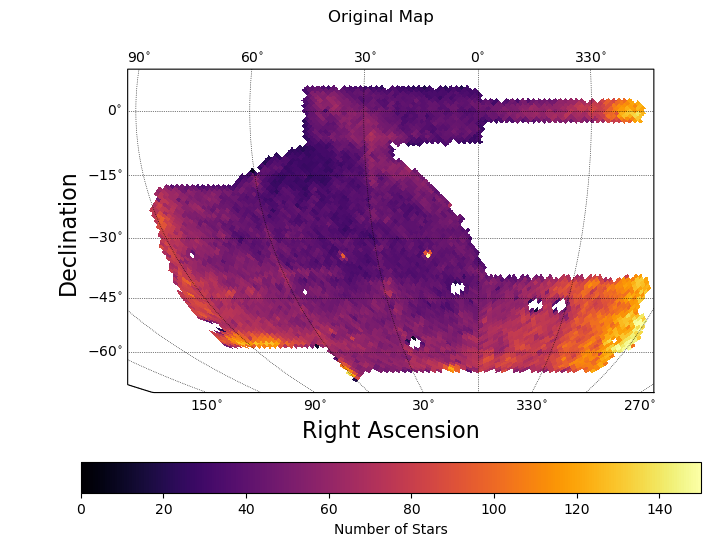

In [21]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspOrig, cmap = 'inferno')
plt.clim(0, 150)
plt.colorbar(location = 'bottom', label = 'Number of Stars')
fig.suptitle('Original Map')
plt.show()

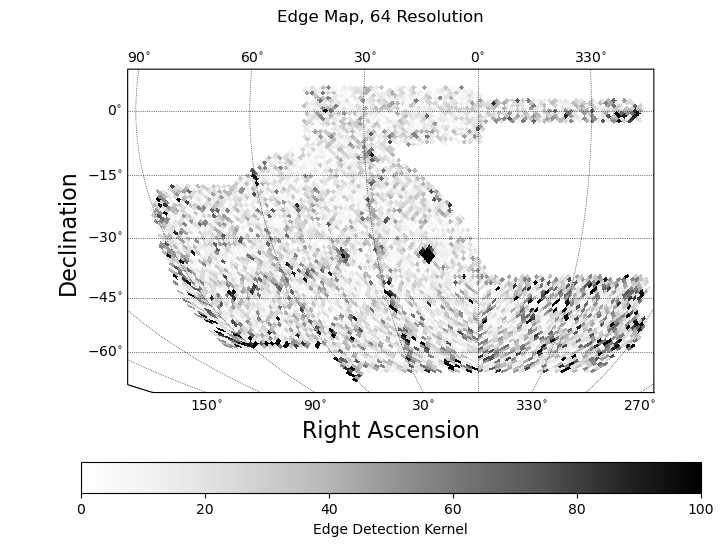

In [22]:
# The default DES projection is a McBrydeSkymap.
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
sp = skyproj.DESSkyproj(ax=ax)
sp.draw_hspmap(hspEdge, cmap = 'Greys')
plt.clim(0, 100)
plt.colorbar(location = 'bottom', label = 'Edge Detection Kernel')
fig.suptitle('Edge Map, ' + str(deRes) + ' Resolution')
plt.show()